# Dyad Position Predictor
Train a neural network to predict dyad positions on a per-position basis from encoded DNA sequences (0-7).

## Data Format Expected:
- Each sample: (dyad_positions, encoded_sequence)
- dyad_positions: list of integers (positions where dyads occur)
- encoded_sequence: list/array of integers (0-7, representing DNA bases)

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

from ChromatinFibers import ChromatinFiber, simulate_chromatin_fibers

## Step 1: Define the Model Architecture

In [2]:
class DyadPredictor(nn.Module):
    """Per-position dyad predictor using Conv1d and bidirectional context."""
    def __init__(self, vocab_size=8, embedding_dim=16, hidden_dim=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.vocab_size = vocab_size
        
        # Embedding layer (map 0-7 to dense vectors)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Conv blocks for local context
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        
        # BiLSTM for global context
        self.lstm = nn.LSTM(hidden_dim, hidden_dim // 2, num_layers=num_layers, 
                           bidirectional=True, dropout=dropout if num_layers > 1 else 0, 
                           batch_first=True)
        
        # Output head
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, x):
        """Forward pass.
        Args:
            x: (batch_size, seq_len) - encoded sequence
        Returns:
            logits: (batch_size, seq_len, 1) - per-position dyad logits
        """
        # Embedding: (batch, seq_len) -> (batch, seq_len, embed_dim)
        x = self.embedding(x)
        
        # Conv blocks: (batch, seq_len, embed_dim) -> (batch, embed_dim, seq_len)
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        
        # Back to (batch, seq_len, hidden_dim)
        x = x.transpose(1, 2)
        
        # LSTM: (batch, seq_len, hidden_dim) -> (batch, seq_len, hidden_dim)
        x, _ = self.lstm(x)
        
        # Per-position classification: (batch, seq_len, hidden_dim) -> (batch, seq_len, 1)
        logits = self.fc(x)
        
        return logits

## Step 2: Define Custom Dataset

In [3]:
class DyadDataset(Dataset):
    """Dataset for dyad position prediction."""
    def __init__(self, data_list, max_seq_len=None):
        """
        Args:
            data_list: list of tuples (dyad_positions, encoded_sequence)
                - dyad_positions: list of integers (positions with dyads)
                - encoded_sequence: list/array of ints (0-7)
            max_seq_len: optional, pad/truncate sequences to this length
        """
        self.data = data_list
        self.max_seq_len = max_seq_len or max(len(seq) for _, seq in data_list)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        dyad_pos, encoded_seq = self.data[idx]
        seq_len = len(encoded_seq)
        
        # Create binary label: 1 if dyad at position, 0 otherwise
        label = np.zeros(seq_len, dtype=np.float32)
        for pos in dyad_pos:
            if 0 <= pos < seq_len:
                label[pos] = 1.0
        
        # Convert to tensors
        seq_tensor = torch.LongTensor(encoded_seq)
        label_tensor = torch.FloatTensor(label)
        
        # Pad/truncate to max_seq_len
        if seq_len < self.max_seq_len:
            pad_len = self.max_seq_len - seq_len
            seq_tensor = torch.nn.functional.pad(seq_tensor, (0, pad_len), value=0)
            label_tensor = torch.nn.functional.pad(label_tensor, (0, pad_len), value=-1)  # -1 for padding
        elif seq_len > self.max_seq_len:
            seq_tensor = seq_tensor[:self.max_seq_len]
            label_tensor = label_tensor[:self.max_seq_len]
        
        return seq_tensor, label_tensor

## Step 3: Load Your Data
Replace this with your actual data loading logic.

In [4]:
# EXAMPLE: Generate synthetic data
def generate_synthetic_data(n_samples=500):
    """Generate synthetic dyad/sequence pairs for demonstration."""
    dyad_positions, _, encoded_seq = simulate_chromatin_fibers(n_samples=n_samples, length=10_000)
    data = [(dyads, seq) for dyads, seq in zip(dyad_positions, encoded_seq)]
    
    print(data[0])
    return data

# Generate or load your data here
print("Loading data...")
all_data = generate_synthetic_data(n_samples=100)  # Replace with your data loading

# Split into train/val/test
n_train = int(0.7 * len(all_data))
n_val = int(0.15 * len(all_data))

train_data = all_data[:n_train]
val_data = all_data[n_train:n_train+n_val]
test_data = all_data[n_train+n_val:]

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")
print(f"Sample: dyad_positions={train_data[0][0]}, seq_len={len(train_data[0][1])}")

Loading data...


100%|██████████| 100/100 [07:14<00:00,  4.35s/it]

(array([  73,  220,  367,  514,  661,  808,  955, 1102, 1257, 1417, 1576,
       1764, 1974, 2126, 2273, 2434, 2592, 2741, 2958, 3111, 3277, 3472,
       3760, 3926, 4080, 4233, 4453, 4713, 4941, 5091, 5276, 5430, 5612,
       5840, 6083, 6285, 6432, 6579, 6756, 6915, 7072, 7254, 7411, 7570,
       7725, 7931, 8088, 8352, 8505, 8651, 8923, 9110, 9262, 9551, 9739,
       9922]), array([2, 0, 2, ..., 7, 7, 3], shape=(10000,), dtype=int8))
Train: 70, Val: 15, Test: 15
Sample: dyad_positions=[  73  220  367  514  661  808  955 1102 1257 1417 1576 1764 1974 2126
 2273 2434 2592 2741 2958 3111 3277 3472 3760 3926 4080 4233 4453 4713
 4941 5091 5276 5430 5612 5840 6083 6285 6432 6579 6756 6915 7072 7254
 7411 7570 7725 7931 8088 8352 8505 8651 8923 9110 9262 9551 9739 9922], seq_len=10000


## Step 4: Create DataLoaders

In [5]:
# Create datasets and dataloaders
train_dataset = DyadDataset(train_data)
val_dataset = DyadDataset(val_data, max_seq_len=train_dataset.max_seq_len)
test_dataset = DyadDataset(test_data, max_seq_len=train_dataset.max_seq_len)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Max sequence length: {train_dataset.max_seq_len}")
print(f"DataLoaders created: train={len(train_loader)} batches, val={len(val_loader)}, test={len(test_loader)}")

Max sequence length: 10000
DataLoaders created: train=3 batches, val=1, test=1


## Step 5: Initialize Model and Training Components

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = DyadPredictor(vocab_size=8, embedding_dim=16, hidden_dim=64, num_layers=2, dropout=0.3)
model = model.to(device)

# Loss function: BCEWithLogitsLoss (combines sigmoid + BCE)
pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='none')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# ReduceLROnPlateau without 'verbose' for compatibility with older PyTorch versions
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cpu
Model parameters: 78,401
Model parameters: 78,401


In [7]:
# Compute a pos_weight from training data (ignore padding where label == -1)

def compute_pos_weight_from_dataset(dataset):
    pos = 0
    neg = 0
    for seq_tensor, label_tensor in dataset:
        arr = np.asarray(label_tensor)
        mask = arr >= 0  # only count real positions, not padding (-1)
        if mask.sum() == 0:
            continue
        pos += int((arr[mask] == 1).sum())
        neg += int((arr[mask] == 0).sum())
    # Avoid division by zero
    if pos == 0:
        print("Warning: no positive examples found in train_dataset; setting pos=1 to avoid division by zero")
        pos = 1
    # pos_weight used by BCEWithLogitsLoss scales the positive class loss: pos_weight = neg/pos
    pw = float(neg) / float(pos)
    return torch.tensor([pw], dtype=torch.float32)

# Compute and clamp pos_weight to a reasonable range to avoid extreme scaling
pos_weight = compute_pos_weight_from_dataset(train_dataset).to(device)
pos_weight = torch.clamp(pos_weight, min=1.0, max=100.0)
print(f"Computed pos_weight: {pos_weight.item():.4f}")

# Define the weighted criterion (reduction='none' so you can mask padding later)
criterion_weighted = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='none')

# Expose for REPL visibility
criterion_weighted


Computed pos_weight: 100.0000


BCEWithLogitsLoss()

## Step 6: Training Loop

In [8]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    
    for seq_batch, label_batch in tqdm(train_loader, desc="Training"):
        seq_batch = seq_batch.to(device)  # (batch, seq_len)
        label_batch = label_batch.to(device)  # (batch, seq_len)
        
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(seq_batch)  # (batch, seq_len, 1)
        logits = logits.squeeze(-1)  # (batch, seq_len)
        
        # Compute loss (ignore padding positions with label=-1)
        loss_per_pos = criterion(logits, label_batch)  # (batch, seq_len)
        mask = (label_batch >= 0).float()  # Mask out padding
        loss = (loss_per_pos * mask).sum() / mask.sum().clamp(min=1)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    """Validate model."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for seq_batch, label_batch in tqdm(val_loader, desc="Validating"):
            seq_batch = seq_batch.to(device)
            label_batch = label_batch.to(device)
            
            logits = model(seq_batch)
            logits = logits.squeeze(-1)
            
            loss_per_pos = criterion(logits, label_batch)
            mask = (label_batch >= 0).float()
            loss = (loss_per_pos * mask).sum() / mask.sum().clamp(min=1)
            
            total_loss += loss.item()
            
            # Store for metrics
            probs = torch.sigmoid(logits)
            all_preds.append(probs.cpu().numpy())
            all_labels.append(label_batch.cpu().numpy())
    
    return total_loss / len(val_loader), all_preds, all_labels

# Training loop
epochs = 50
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 5
patience_counter = 0

print("Starting training...")
for epoch in range(epochs):
    # train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    # val_loss, _, _ = validate(model, val_loader, criterion, device)
    
    train_loss = train_epoch(model, train_loader, criterion_weighted, optimizer, device)   # ✅ RIGHT
    val_loss, _, _ = validate(model, val_loader, criterion_weighted, device)             # ✅ RIGHT

    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_dyad_predictor.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    scheduler.step(val_loss)

print("Training completed!")

Starting training...


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]



Epoch 1/50 | Train Loss: 1.0510 | Val Loss: 1.0440


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]



Epoch 2/50 | Train Loss: 1.0375 | Val Loss: 1.0345


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]



Epoch 3/50 | Train Loss: 1.0211 | Val Loss: 1.0217


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]



Epoch 4/50 | Train Loss: 1.0093 | Val Loss: 1.0036


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]



Epoch 5/50 | Train Loss: 0.9922 | Val Loss: 0.9799


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]



Epoch 6/50 | Train Loss: 0.9644 | Val Loss: 0.9512


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]



Epoch 7/50 | Train Loss: 0.9285 | Val Loss: 0.9131


Validating: 100%|██████████| 1/1 [00:03<00:00,  3.93s/it]



Epoch 8/50 | Train Loss: 0.8892 | Val Loss: 0.8631


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]



Epoch 9/50 | Train Loss: 0.8544 | Val Loss: 0.8172


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]



Epoch 10/50 | Train Loss: 0.8032 | Val Loss: 0.7737


Validating: 100%|██████████| 1/1 [00:08<00:00,  8.38s/it]



Epoch 11/50 | Train Loss: 0.7486 | Val Loss: 0.7220


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]



Epoch 12/50 | Train Loss: 0.7137 | Val Loss: 0.6952


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]



Epoch 13/50 | Train Loss: 0.6936 | Val Loss: 0.6763


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]



Epoch 14/50 | Train Loss: 0.6793 | Val Loss: 0.6738


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]



Epoch 15/50 | Train Loss: 0.6565 | Val Loss: 0.6538


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]



Epoch 16/50 | Train Loss: 0.6380 | Val Loss: 0.6287


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]



Epoch 17/50 | Train Loss: 0.6281 | Val Loss: 0.6185


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]



Epoch 18/50 | Train Loss: 0.6148 | Val Loss: 0.6093


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]



Epoch 19/50 | Train Loss: 0.6125 | Val Loss: 0.5947


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]



Epoch 20/50 | Train Loss: 0.6048 | Val Loss: 0.5822


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Epoch 21/50 | Train Loss: 0.5897 | Val Loss: 0.5833


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]



Epoch 22/50 | Train Loss: 0.5849 | Val Loss: 0.5775


Validating: 100%|██████████| 1/1 [00:03<00:00,  3.80s/it]


Epoch 23/50 | Train Loss: 0.5840 | Val Loss: 0.5862


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]



Epoch 24/50 | Train Loss: 0.5846 | Val Loss: 0.5765


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]



Epoch 25/50 | Train Loss: 0.5747 | Val Loss: 0.5705


Validating: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]



Epoch 26/50 | Train Loss: 0.5728 | Val Loss: 0.5616


Validating: 100%|██████████| 1/1 [00:04<00:00,  4.20s/it]


Epoch 27/50 | Train Loss: 0.5623 | Val Loss: 0.5597


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]



Epoch 28/50 | Train Loss: 0.5603 | Val Loss: 0.5598


Validating: 100%|██████████| 1/1 [00:05<00:00,  5.55s/it]


Epoch 29/50 | Train Loss: 0.5604 | Val Loss: 0.5633


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]



Epoch 30/50 | Train Loss: 0.5567 | Val Loss: 0.5593


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]



Epoch 31/50 | Train Loss: 0.5481 | Val Loss: 0.5573


Validating: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it]



Epoch 32/50 | Train Loss: 0.5437 | Val Loss: 0.5627


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch 33/50 | Train Loss: 0.5430 | Val Loss: 0.5593


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]



Epoch 34/50 | Train Loss: 0.5349 | Val Loss: 0.5473


Validating: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]



Epoch 35/50 | Train Loss: 0.5343 | Val Loss: 0.5619


Validating: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]


Epoch 36/50 | Train Loss: 0.5306 | Val Loss: 0.5503


Validating: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]



Epoch 37/50 | Train Loss: 0.5204 | Val Loss: 0.5517


Validating: 100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


Epoch 38/50 | Train Loss: 0.5206 | Val Loss: 0.5484


Validating: 100%|██████████| 1/1 [00:06<00:00,  6.04s/it]



Epoch 39/50 | Train Loss: 0.5074 | Val Loss: 0.5335


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]



Epoch 40/50 | Train Loss: 0.5144 | Val Loss: 0.5287


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]



Epoch 41/50 | Train Loss: 0.4942 | Val Loss: 0.5320


Validating: 100%|██████████| 1/1 [00:06<00:00,  6.23s/it]


Epoch 42/50 | Train Loss: 0.5009 | Val Loss: 0.5290


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]



Epoch 43/50 | Train Loss: 0.4892 | Val Loss: 0.5261


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]



Epoch 44/50 | Train Loss: 0.4751 | Val Loss: 0.5220


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


Epoch 45/50 | Train Loss: 0.4789 | Val Loss: 0.5308


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Epoch 46/50 | Train Loss: 0.4670 | Val Loss: 0.5235


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Epoch 47/50 | Train Loss: 0.5142 | Val Loss: 0.5241


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]



Epoch 48/50 | Train Loss: 0.4654 | Val Loss: 0.5201


Validating: 100%|██████████| 1/1 [00:04<00:00,  4.64s/it]



Epoch 49/50 | Train Loss: 0.4662 | Val Loss: 0.5154


Validating: 100%|██████████| 1/1 [00:04<00:00,  4.20s/it]



Epoch 50/50 | Train Loss: 0.4550 | Val Loss: 0.5105
Training completed!
Training completed!


## Step 7: Plot Training History

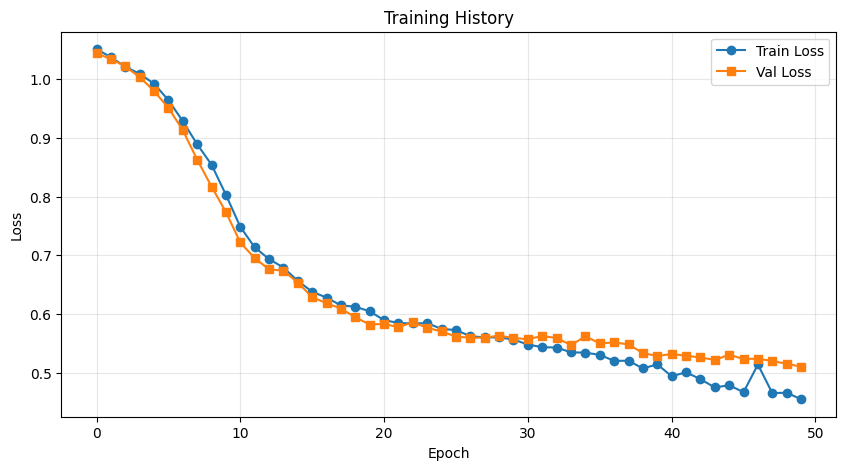

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Step 8: Evaluate on Test Set

In [10]:
# Load best model
model.load_state_dict(torch.load('best_dyad_predictor.pt'))

# Evaluate on test set
model.eval()
# test_loss, test_preds, test_labels = validate(model, test_loader, criterion, device)
test_loss, test_preds, test_labels = validate(model, test_loader, criterion_weighted, device)

print(f"Test Loss: {test_loss:.4f}")

# Compute metrics
all_preds_flat = np.concatenate(test_preds).ravel()
all_labels_flat = np.concatenate(test_labels).ravel()

# Remove padding positions
valid_mask = all_labels_flat >= 0
all_preds_flat = all_preds_flat[valid_mask]
all_labels_flat = all_labels_flat[valid_mask]

# Threshold at 0.5
# predictions_binary = (all_preds_flat >= 0.5).astype(int)
# Threshold at 0.3 (lower for imbalanced data with weighted loss)
predictions_binary = (all_preds_flat >= 0.3).astype(int)


# Metrics: try sklearn, fallback to numpy implementations if missing
try:
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    sklearn_available = True
except Exception as e:
    sklearn_available = False
    import warnings
    warnings.warn("scikit-learn not installed; using numpy fallback for basic metrics. Install with: pip install scikit-learn")
    def accuracy_score(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        return float((y_true == y_pred).mean())
    def precision_score(y_true, y_pred, zero_division=0):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        tp = int(((y_true == 1) & (y_pred == 1)).sum())
        fp = int(((y_true == 0) & (y_pred == 1)).sum())
        denom = tp + fp
        if denom == 0:
            return float(zero_division)
        return float(tp / denom)
    def recall_score(y_true, y_pred, zero_division=0):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        tp = int(((y_true == 1) & (y_pred == 1)).sum())
        fn = int(((y_true == 1) & (y_pred == 0)).sum())
        denom = tp + fn
        if denom == 0:
            return float(zero_division)
        return float(tp / denom)
    def f1_score(y_true, y_pred, zero_division=0):
        p = precision_score(y_true, y_pred, zero_division)
        r = recall_score(y_true, y_pred, zero_division)
        if (p + r) == 0:
            return float(zero_division)
        return 2 * (p * r) / (p + r)
    def roc_auc_score(y_true, y_score):
        y_true = np.asarray(y_true)
        y_score = np.asarray(y_score)
        # require both classes present
        if len(np.unique(y_true)) < 2:
            return float('nan')
        # Sort scores descending
        desc = np.argsort(-y_score)
        y_true_sorted = y_true[desc]
        # cumulative true/false positives
        tp = np.cumsum(y_true_sorted == 1)
        fp = np.cumsum(y_true_sorted == 0)
        tp_total = tp[-1]
        fp_total = fp[-1]
        if tp_total == 0 or fp_total == 0:
            return float('nan')
        tpr = np.concatenate([[0.0], tp / tp_total])
        fpr = np.concatenate([[0.0], fp / fp_total])
        return float(np.trapz(tpr, fpr))

# Calculate metrics
acc = accuracy_score(all_labels_flat, predictions_binary)
prec = precision_score(all_labels_flat, predictions_binary, zero_division=0)
rec = recall_score(all_labels_flat, predictions_binary, zero_division=0)
f1 = f1_score(all_labels_flat, predictions_binary, zero_division=0)
auc = roc_auc_score(all_labels_flat, all_preds_flat)

print(f"\nTest Metrics:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall:    {rec:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print(f"  ROC-AUC:   {auc if not np.isnan(auc) else 'nan'}")

Validating: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]



Test Loss: 0.5183

Test Metrics:
  Accuracy:  0.7775
  Precision: 0.0231
  Recall:    0.9599
  F1-Score:  0.0451
  ROC-AUC:   0.9140423095204053

Test Metrics:
  Accuracy:  0.7775
  Precision: 0.0231
  Recall:    0.9599
  F1-Score:  0.0451
  ROC-AUC:   0.9140423095204053


## Step 9: Make Predictions on New Data

In [18]:
def predict_dyads(model, encoded_sequence, threshold=0.2, device='cpu'):
    """
    Predict dyad positions for a single sequence.
    
    Args:
        model: trained DyadPredictor
        encoded_sequence: list/array of integers (0-7)
        threshold: probability threshold for positive class (default 0.5)
        device: torch device
    
    Returns:
        dyad_positions: list of predicted dyad positions
        probabilities: array of per-position probabilities
    """
    # model.eval()
    # with torch.no_grad():
    #     seq_tensor = torch.LongTensor(encoded_sequence).unsqueeze(0).to(device)  # (1, seq_len)
    #     logits = model(seq_tensor)  # (1, seq_len, 1)
    #     probs = torch.sigmoid(logits).squeeze().cpu().numpy()  # (seq_len,)
    
    # dyad_positions = np.where(probs >= threshold)[0].tolist()
    # return dyad_positions, probs


    model.eval()  # CRITICAL!
    with torch.no_grad():
        seq_tensor = torch.LongTensor(encoded_sequence).unsqueeze(0).to(device)
        logits = model(seq_tensor)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()
    
    dyad_positions = np.where(probs >= threshold)[0].tolist()
    return dyad_positions, probs

# Example: predict on first test sample
test_seq = test_data[0][1]
true_dyads = test_data[0][0]

pred_dyads, pred_probs = predict_dyads(model, test_seq, device=device)

print(f"Test sequence length: {len(test_seq)}")
print(f"True dyad positions: {true_dyads}")
print(f"Predicted dyad positions: {pred_dyads}")
# print(f"\nPer-position probabilities:")
# for i, prob in enumerate(pred_probs):
#     print(f"  Position {i}: {prob:.3f}")

plt.plot

Test sequence length: 10000
True dyad positions: [  73  368  571  724  871 1084 1285 1439 1625 1782 1935 2086 2234 2409
 2580 2754 2957 3238 3423 3573 3730 3899 4058 4222 4374 4563 4723 4871
 5018 5173 5346 5494 5646 5814 5994 6171 6321 6473 6687 6838 6995 7152
 7317 7473 7667 7824 8015 8176 8331 8554 8716 8883 9041 9213 9365 9609
 9805]
Predicted dyad positions: [53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730,

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

## Step 10: Visualize Predictions

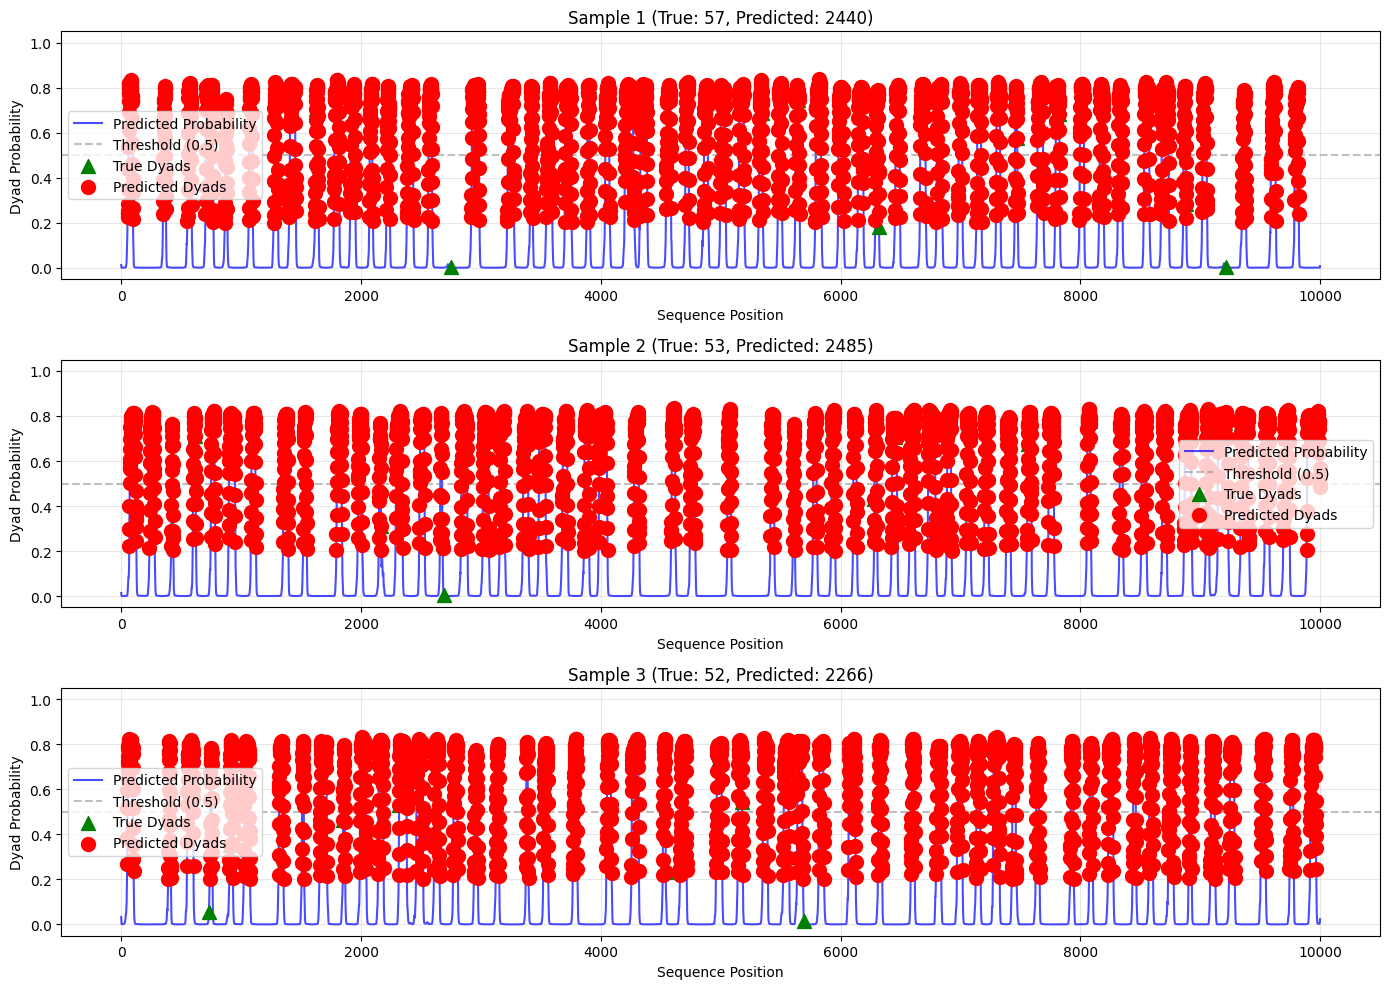

In [ ]:
# Visualize predictions for test samples (robust: filter/deduplicate dyad positions)
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for idx in range(min(3, len(test_data))):
    test_seq = test_data[idx][1]
    true_dyads = test_data[idx][0]

    pred_dyads, pred_probs = predict_dyads(model, test_seq, device=device)

    ax = axes[idx]
    positions = np.arange(len(test_seq))

    # Plot probabilities
    ax.plot(positions, pred_probs, 'b-', alpha=0.7, label='Predicted Probability')
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Threshold (0.5)')

    # Normalize/validate true_dyads and pred_dyads: flatten, convert to ints, filter in-range
    def normalize_positions(pos_list, seq_len):
        if pos_list is None:
            return np.array([], dtype=int)
        arr = np.asarray(pos_list)
        # If nested, flatten
        arr = arr.flatten()
        # If boolean mask (same length as sequence), convert to indices
        if arr.dtype == bool and arr.size == seq_len:
            arr = np.where(arr)[0]
        # Convert to integers safely
        try:
            arr = arr.astype(int)
        except Exception:
            # try element-wise cast
            arr = np.array([int(x) for x in arr if x is not None], dtype=int)
        # Filter valid range
        mask = (arr >= 0) & (arr < seq_len)
        arr = arr[mask]
        # Deduplicate and sort
        if arr.size == 0:
            return np.array([], dtype=int)
        arr = np.unique(arr)
        return arr

    seq_len = len(test_seq)
    true_pos = normalize_positions(true_dyads, seq_len)
    pred_pos = normalize_positions(pred_dyads, seq_len)

    # Plot predicted dyads first (lower z-order, slightly transparent)
    if pred_pos.size > 0:
        ax.scatter(pred_pos, pred_probs[pred_pos],
                  color='red', s=80, marker='o', label='Predicted Dyads', zorder=4, alpha=0.7)

    # Then plot true dyads on top with a distinctive style (higher z-order)
    if true_pos.size > 0:
        ax.scatter(true_pos, pred_probs[true_pos],
                  facecolors='none', edgecolors='green', s=150, linewidths=2, marker='^',
                  label='True Dyads', zorder=6)

    ax.set_xlabel('Sequence Position')
    ax.set_ylabel('Dyad Probability')
    ax.set_title(f'Sample {idx+1} (True total: {len(np.asarray(true_dyads).flatten())}, Plotted true: {len(true_pos)}, Predicted: {len(pred_pos)})')

    # Create a clean legend without duplicate labels (keep order)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()


## Step 11: Save Model for Later Use

In [13]:
# Save model and configuration
model_config = {
    'vocab_size': 8,
    'embedding_dim': 16,
    'hidden_dim': 64,
    'num_layers': 2,
    'dropout': 0.3,
    'max_seq_len': train_dataset.max_seq_len
}

# Save config
with open('dyad_predictor_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

# Model is already saved as 'best_dyad_predictor.pt'
print("Model and config saved!")
print(f"Config: {model_config}")

Model and config saved!
Config: {'vocab_size': 8, 'embedding_dim': 16, 'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.3, 'max_seq_len': 10000}


## Step 12: Load Saved Model

In [14]:
# Load model for inference
import json

# Load config
with open('dyad_predictor_config.json', 'r') as f:
    config = json.load(f)

# Create model
loaded_model = DyadPredictor(**{k: v for k, v in config.items() if k != 'max_seq_len'})
loaded_model.load_state_dict(torch.load('best_dyad_predictor.pt'))
loaded_model = loaded_model.to(device)
loaded_model.eval()

# Use for predictions
new_seq = [1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4]
dyads, probs = predict_dyads(loaded_model, new_seq, device=device)
print(f"Predicted dyads: {dyads}")
print(f"Probabilities: {probs}")

Predicted dyads: []
Probabilities: [0.01056277 0.00265134 0.00100894 0.00068256 0.00060164 0.00056263
 0.00057728 0.00062884 0.00074844 0.00107824 0.0024931  0.00792084]
